In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import PCA

import optuna
from optuna.integration import OptunaSearchCV

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
load_dotenv()

train_mmse = os.environ.get("TRAIN_MMSE")

train = os.path.join(os.environ.get("TRAIN"), 'adresso-features-train.csv')
train_augmented = os.path.join(os.environ.get("TRAIN"), 'adresso-features-augmented-train.csv')
test = os.path.join(os.environ.get("TEST"), 'adresso-features-test.csv')

train_openl3 = os.path.join(os.environ.get("TRAIN"), 'adresso-openl3-pca-embeddings-train.csv')
test_openl3 = os.path.join(os.environ.get("TEST"), 'adresso-openl3-pca-embeddings-test.csv')

truth_task2 = os.path.join(os.environ.get("TRUTH_TASK2"))

### Reading Acoustic Data

In [5]:
df = pd.read_csv(train)
df.head()

,MFCCs_mean,MFCCs_std,MFCCs_min,MFCCs_max,MFCCs_Q1,MFCCs_Q2,MFCCs_Q3,MFCCs_d1_mean,MFCCs_d1_std,MFCCs_d1_min,...,SNR,Pitch,Duration,Words,HNR_mean,HNR_std,HNR_max,adressfname,dx,mmse
0,-20.392339,123.700237,-557.285820,247.689651,-12.589321,-0.933948,13.461918,0.012523,4.187519,-41.328216,...,37650.060927,60.659047,224.206916,156,-165.855528,77.315477,27.117794,adrso024,ad,20
1,-27.227270,143.403495,-702.302502,241.789555,-7.330947,1.563355,12.549985,0.014154,2.828714,-30.478220,...,6707.629520,38.316251,170.779977,19,-186.915390,50.495271,23.753750,adrso025,ad,11
2,-19.190823,120.809974,-713.867854,216.206818,-10.479501,5.762882,22.069600,0.016527,2.615273,-41.517980,...,2874.613576,31.260772,69.915873,7,-176.800520,65.050773,27.822335,adrso027,ad,18
3,-26.171295,147.473792,-728.981896,211.866351,-6.662497,2.935268,18.348571,0.047427,2.115747,-14.495990,...,2882.739511,46.486516,52.148912,6,-196.003998,28.588117,31.310324,adrso028,ad,18
4,-24.511270,122.793868,-599.425992,223.091272,-6.075605,2.094260,14.738329,0.013892,2.622402,-37.899971,...,12348.669892,97.143278,54.506893,7,-190.825256,43.328165,28.061867,adrso031,ad,26


In [6]:
test_df = pd.read_csv(test)
test_df.head()

,MFCCs_mean,MFCCs_std,MFCCs_min,MFCCs_max,MFCCs_Q1,MFCCs_Q2,MFCCs_Q3,MFCCs_d1_mean,MFCCs_d1_std,MFCCs_d1_min,...,RMS_Energy_Q2,RMS_Energy_Q3,SNR,Pitch,Duration,Words,HNR_mean,HNR_std,HNR_max,adressfname
0,-23.879873,131.128569,-537.000015,240.187874,-3.831189,3.159696,10.574533,0.035797,5.871200,-33.539985,...,0.003991,0.052062,1.031803e+06,85.753026,58.327959,81,-145.944542,93.404086,33.843171,adrsdt1
1,-22.916366,114.285416,-519.128245,216.476958,-13.047467,1.853330,13.223973,0.016850,5.450128,-40.721839,...,0.018102,0.053067,2.029699e+05,119.694230,46.677914,72,-140.492581,95.104062,32.589739,adrsdt10
2,-19.238629,116.446145,-520.264291,240.262613,-14.222423,-0.461745,9.374266,0.004707,6.063852,-42.140066,...,0.059429,0.107949,2.516352e+06,114.396639,62.832925,164,-94.553701,105.915648,30.725673,adrsdt11
3,-23.374392,125.694430,-547.389531,231.887660,-13.363540,0.371793,5.625976,-0.001700,5.809461,-43.575232,...,0.051530,0.104460,3.640965e+06,140.411818,72.848912,162,-93.449538,109.587233,36.046877,adrsdt12
4,-21.564015,111.063830,-526.444365,237.651498,-14.790231,-0.537706,9.264870,0.001318,5.489112,-52.197976,...,0.013169,0.107892,2.778914e+06,116.897670,29.613946,49,-116.455011,103.176791,29.393578,adrsdt13


In [7]:
ground_truth_df = pd.read_csv(truth_task2)
ground_truth_df.head()

,ID,MMSE
0,adrsdt15,30
1,adrsdt40,28
2,adrsdt26,29
3,adrsdt67,30
4,adrsdt58,29


#### Data Cleaning

In [8]:
snr = df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

df['SNR'] = snr

In [9]:
augmented_df = pd.read_csv(train_augmented)

# Removing inf values from SNR
snr = augmented_df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

augmented_df['SNR'] = snr

In [10]:
# Removing inf values from SNR
snr = test_df['SNR']
snr_without_inf = snr[snr != float('inf')]
snr[snr == float('inf')] = np.sort(snr_without_inf)[-1]

test_df['SNR'] = snr

In [11]:
# Merging the test features with the ground truth
test_df = pd.merge(test_df, ground_truth_df, left_on='adressfname', right_on='ID')

#### Model Building

In [12]:
# Features and target variable
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['mmse']

X_test = test_df.drop(['adressfname', 'MMSE', 'ID'], axis=1)

In [13]:
# Scaling the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

In [14]:
# Define parameter distribution for Lasso Regression
param_distribution = {
    'alpha': optuna.distributions.FloatDistribution(0.1, 10),
    'max_iter': optuna.distributions.IntDistribution(700, 2000)
}

# Create Lasso Regression model
lasso_model = Lasso()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lasso_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding rmse for each model
print(f"Best Parameters for Lasso Regression: {optuna_search.best_params_}")
print(f"Best Mean RMSE for Lasso Regression: {optuna_search.best_score_:.4f}")

[I 2024-04-23 23:27:18,582] A new study created in memory with name: no-name-c6249ce7-364d-41e9-a45f-8c210b658f6b
[I 2024-04-23 23:27:18,615] Trial 0 finished with value: -66.35988029952479 and parameters: {'alpha': 0.8242417439275096, 'max_iter': 1124}. Best is trial 0 with value: -66.35988029952479.


[I 2024-04-23 23:27:18,636] Trial 1 finished with value: -64.21265046058716 and parameters: {'alpha': 5.211245519540598, 'max_iter': 1680}. Best is trial 1 with value: -64.21265046058716.
[I 2024-04-23 23:27:18,654] Trial 2 finished with value: -64.21265046058716 and parameters: {'alpha': 8.544893301693408, 'max_iter': 953}. Best is trial 1 with value: -64.21265046058716.
[I 2024-04-23 23:27:18,676] Trial 3 finished with value: -64.21265046058716 and parameters: {'alpha': 5.30597560873839, 'max_iter': 1627}. Best is trial 1 with value: -64.21265046058716.
[I 2024-04-23 23:27:18,694] Trial 4 finished with value: -64.21265046058716 and parameters: {'alpha': 8.21017346856662, 'max_iter': 1381}. Best is trial 1 with value: -64.21265046058716.
[I 2024-04-23 23:27:18,710] Trial 5 finished with value: -64.21265046058716 and parameters: {'alpha': 3.534937031863826, 'max_iter': 1496}. Best is trial 1 with value: -64.21265046058716.
[I 2024-04-23 23:27:18,728] Trial 6 finished with value: -64.21

Best Parameters for Lasso Regression: {'alpha': 5.211245519540598, 'max_iter': 1680}
Best Mean RMSE for Lasso Regression: -64.2127


In [16]:
# Define parameter distribution for RandomForestRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 500),
    'max_depth': optuna.distributions.IntDistribution(5, 15),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
}

# Create RandomForestRegressor model
rf_model = RandomForestRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(rf_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for RandomForestRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for RandomForestRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-23 23:41:30,028] A new study created in memory with name: no-name-fbd0457f-5a3c-4259-ae71-140a05733f20


[I 2024-04-23 23:41:58,294] Trial 0 finished with value: -68.20179079998907 and parameters: {'n_estimators': 421, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 0 with value: -68.20179079998907.
[I 2024-04-23 23:42:10,734] Trial 1 finished with value: -67.2509392829746 and parameters: {'n_estimators': 152, 'max_depth': 11, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 1 with value: -67.2509392829746.
[I 2024-04-23 23:42:27,672] Trial 2 finished with value: -68.43702569865961 and parameters: {'n_estimators': 293, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 1 with value: -67.2509392829746.
[I 2024-04-23 23:42:44,604] Trial 3 finished with value: -66.69693579849957 and parameters: {'n_estimators': 174, 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 3 with value: -66.69693579849957.
[I 2024-04-23 23:42:54,940] Trial 4 finished with value: -67.96786854069349 and parameters: {'n

Best Parameters for RandomForestRegressor: {'n_estimators': 128, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best Mean RMSE for RandomForestRegressor: -64.7220


In [17]:
# Define parameter distribution for GradientBoostingRegressor
param_distribution = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4),
    'max_depth': optuna.distributions.IntDistribution(3, 10)
}

# Create GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(gb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for GradientBoostingRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for GradientBoostingRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 01:07:23,649] A new study created in memory with name: no-name-080fa753-4be6-4c7d-b5d7-1c13a9c7e7d6


[I 2024-04-24 01:07:31,566] Trial 0 finished with value: -69.6579720742796 and parameters: {'learning_rate': 0.06831185200301393, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5}. Best is trial 0 with value: -69.6579720742796.
[I 2024-04-24 01:07:37,525] Trial 1 finished with value: -69.53887674310981 and parameters: {'learning_rate': 0.03248076286517929, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 3}. Best is trial 1 with value: -69.53887674310981.
[I 2024-04-24 01:07:46,440] Trial 2 finished with value: -72.07256936436875 and parameters: {'learning_rate': 0.061993147312133276, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 6}. Best is trial 1 with value: -69.53887674310981.
[I 2024-04-24 01:07:53,770] Trial 3 finished with value: -69.23631616920262 and parameters: {'learning_rate': 0.05938335768567778, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 4}. Best is trial 3 with value: -69.23631616920262.
[I 2024-04-24 01:07:59,727]

Best Parameters for GradientBoostingRegressor: {'learning_rate': 0.0063508705270543435, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_depth': 7}
Best Mean RMSE for GradientBoostingRegressor: -61.3766


In [18]:
# Define parameter distribution for XGBRegressor
param_distribution = {
    'booster': optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-3, 1e-1)
}

# Create XGBRegressor model
xgb_model = XGBRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(xgb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for XGBRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for XGBRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 02:33:03,709] A new study created in memory with name: no-name-a43b0e5a-917a-464d-b9b6-03afa3dca43a
[I 2024-04-24 02:33:06,518] Trial 0 finished with value: -73.66871988825247 and parameters: {'booster': 'gbtree', 'learning_rate': 0.07484123619835013, 'max_depth': 7, 'reg_lambda': 0.05788383972800824}. Best is trial 0 with value: -73.66871988825247.
[I 2024-04-24 02:33:09,923] Trial 1 finished with value: -73.57352275708146 and parameters: {'booster': 'gbtree', 'learning_rate': 0.030035478686185314, 'max_depth': 7, 'reg_lambda': 0.06435707009841468}. Best is trial 1 with value: -73.57352275708146.
[I 2024-04-24 02:33:10,029] Trial 2 finished with value: -69.1165856969454 and parameters: {'booster': 'gblinear', 'learning_rate': 0.019664878632460716, 'max_depth': 10, 'reg_lambda': 0.07772049600597511}. Best is trial 2 with value: -69.1165856969454.
[I 2024-04-24 02:33:10,103] Trial 3 finished with value: -69.26020288935783 and parameters: {'booster': 'gblinear', 'learning_r

Best Parameters for XGBRegressor: {'booster': 'gbtree', 'learning_rate': 0.005738864928012032, 'max_depth': 6, 'reg_lambda': 0.07138694147909755}
Best Mean RMSE for XGBRegressor: -61.6207


In [19]:
# Define parameter distribution for LGBMRegressor
param_distribution = {
    'boosting_type': optuna.distributions.CategoricalDistribution(['dart', 'gbdt']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'n_estimators': optuna.distributions.IntDistribution(100, 500)
}

# Create LGBMRegressor model
lgbm_model = LGBMRegressor(verbose=-1)

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lgbm_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for LGBMRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for LGBMRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 02:52:01,074] A new study created in memory with name: no-name-aa6ce690-097d-418a-9859-e13d56840196
[I 2024-04-24 02:52:01,886] Trial 0 finished with value: -81.76915646237676 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.015315432053311456, 'max_depth': 5, 'n_estimators': 398}. Best is trial 0 with value: -81.76915646237676.
[I 2024-04-24 02:52:02,124] Trial 1 finished with value: -93.2202064644897 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.03503649658827916, 'max_depth': 8, 'n_estimators': 173}. Best is trial 0 with value: -81.76915646237676.
[I 2024-04-24 02:52:02,299] Trial 2 finished with value: -208.42651827682943 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0040329110163525176, 'max_depth': 4, 'n_estimators': 141}. Best is trial 0 with value: -81.76915646237676.
[I 2024-04-24 02:52:02,637] Trial 3 finished with value: -67.22740879956102 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.06264597541439888, '

Best Parameters for LGBMRegressor: {'boosting_type': 'dart', 'learning_rate': 0.07281616534624712, 'max_depth': 4, 'n_estimators': 256}
Best Mean RMSE for LGBMRegressor: -64.1051


In [20]:
# Define parameter distribution for AdaBoostRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 600),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'loss': optuna.distributions.CategoricalDistribution(['linear', 'square', 'exponential'])
}

# Create AdaBoostRegressor model
adaboost_model = AdaBoostRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(adaboost_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for AdaBoostRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for AdaBoostRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 02:55:30,898] A new study created in memory with name: no-name-472e9a66-9c96-4751-82ab-ddb54941b966
[I 2024-04-24 02:55:43,509] Trial 0 finished with value: -69.53958306178771 and parameters: {'n_estimators': 364, 'learning_rate': 0.03818138126289236, 'loss': 'linear'}. Best is trial 0 with value: -69.53958306178771.
[I 2024-04-24 02:56:03,691] Trial 1 finished with value: -65.59562704107172 and parameters: {'n_estimators': 563, 'learning_rate': 0.04589809992635084, 'loss': 'exponential'}. Best is trial 1 with value: -65.59562704107172.
[I 2024-04-24 02:56:17,206] Trial 2 finished with value: -67.42152821571061 and parameters: {'n_estimators': 359, 'learning_rate': 0.06886064765938116, 'loss': 'linear'}. Best is trial 1 with value: -65.59562704107172.
[I 2024-04-24 02:56:33,559] Trial 3 finished with value: -68.11384505105748 and parameters: {'n_estimators': 494, 'learning_rate': 0.0763244621609511, 'loss': 'square'}. Best is trial 1 with value: -65.59562704107172.
[I 202

Best Parameters for AdaBoostRegressor: {'n_estimators': 539, 'learning_rate': 0.08662421018406125, 'loss': 'exponential'}
Best Mean RMSE for AdaBoostRegressor: -63.3948


In [21]:
# Define parameter distribution for SVR
param_distribution = {
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'rbf', 'sigmoid']),
    'C': optuna.distributions.FloatDistribution(1e-3, 1e3),
    'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto'])
}

# Create SVR model
svr_model = SVR()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(svr_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_scaled, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for SVR: {optuna_search.best_params_}")
print(f"Best Mean RMSE for SVR: {optuna_search.best_score_:.4f}")

[I 2024-04-24 05:24:33,285] A new study created in memory with name: no-name-b610e602-5809-4bb7-bd77-568f008112cf
[I 2024-04-24 05:26:00,895] Trial 0 finished with value: -158.83509800186235 and parameters: {'kernel': 'linear', 'C': 476.092005919411, 'gamma': 'scale'}. Best is trial 0 with value: -158.83509800186235.
[I 2024-04-24 05:28:55,926] Trial 1 finished with value: -159.6049569708191 and parameters: {'kernel': 'linear', 'C': 661.1617889987191, 'gamma': 'scale'}. Best is trial 0 with value: -158.83509800186235.
[I 2024-04-24 05:28:56,088] Trial 2 finished with value: -102.98486753471798 and parameters: {'kernel': 'linear', 'C': 5.339698814282832, 'gamma': 'auto'}. Best is trial 2 with value: -102.98486753471798.
[I 2024-04-24 05:28:56,114] Trial 3 finished with value: -89.98696916523699 and parameters: {'kernel': 'rbf', 'C': 310.80024261983294, 'gamma': 'scale'}. Best is trial 3 with value: -89.98696916523699.
[I 2024-04-24 05:28:56,164] Trial 4 finished with value: -110991.0439

Best Parameters for SVR: {'kernel': 'sigmoid', 'C': 3.265031308164719, 'gamma': 'auto'}
Best Mean RMSE for SVR: -78.7971


In [ ]:
linear_regression = LinearRegression()

catboost_model = CatBoostRegressor(verbose=0)

# Storing best hypertuned parameters for Lasso Regression
lasso_best_params = {'alpha': 1.9700160296938087, 'max_iter': 747}
best_lasso = Lasso(**lasso_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 145, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 1}
best_rf = RandomForestRegressor(**rf_best_params)

# Storing the best hypertuned parameters for Gradient Boosting
gb_best_params = {'learning_rate': 0.001570031365870352, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 9}
best_gb = GradientBoostingRegressor(**gb_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gbtree', 'learning_rate': 0.0018534104668020506, 'max_depth': 4, 'reg_lambda': 0.0012344682052898765}
best_xgb = XGBRegressor(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.0010000331345156176, 'max_depth': 5, 'n_estimators': 100}
best_lgbm = LGBMRegressor(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 169, 'learning_rate': 0.04476134875454807, 'loss': 'square'}
best_ada = AdaBoostRegressor(**ada_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'kernel': 'sigmoid', 'C': 3.22963010011418, 'gamma': 'auto'}
best_svm = SVR(**svm_best_params)

In [ ]:
# Training the hypertuned models
linear_regression.fit(X_scaled, y)
catboost_model.fit(X, y)
best_lasso.fit(X_scaled, y)
best_rf.fit(X_scaled, y)
best_gb.fit(X_scaled, y)
best_xgb.fit(X_scaled, y)
best_lgbm.fit(X_scaled, y)
best_ada.fit(X_scaled, y)
best_svm.fit(X_scaled, y)

print("All hypertuned models trained")

All hypertuned models trained


In [ ]:
predictions = linear_regression.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Linear Regression RMSE: {rmse:.4f}')

predictions = catboost_model.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'CatBoost RMSE: {rmse:.4f}')

predictions = best_lasso.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Lasso RMSE: {rmse:.4f}')

predictions = best_rf.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Random Forest RMSE: {rmse:.4f}')

predictions = best_gb.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Gradient Boosting RMSE: {rmse:.4f}')

predictions = best_xgb.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'XGBoost RMSE: {rmse:.4f}')

predictions = best_lgbm.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'LightGBM RMSE: {rmse:.4f}')

predictions = best_ada.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'AdaBoost RMSE: {rmse:.4f}')

predictions = best_svm.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'SVM RMSE: {rmse:.4f}')

Linear Regression RMSE: 7.4168
CatBoost RMSE: 6.8963
Lasso RMSE: 6.5511
Random Forest RMSE: 6.8145
Gradient Boosting RMSE: 6.5338
XGBoost RMSE: 6.6277
LightGBM RMSE: 6.5186
AdaBoost RMSE: 6.7399
SVM RMSE: 6.4752


In [22]:
# Features and target variable for the augmented dataset
X_augmented = augmented_df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y_augmented = augmented_df['mmse']

X_test = test_df.drop(['adressfname', 'MMSE', 'ID'], axis=1)

In [24]:
# Scaler for the augmented dataset
scaler = StandardScaler()
X_augmented_scaled = scaler.fit_transform(X_augmented)

In [ ]:
# Define parameter distribution for Lasso Regression
param_distribution = {
    'alpha': optuna.distributions.FloatDistribution(0.1, 10),
    'max_iter': optuna.distributions.IntDistribution(700, 2000)
}

# Create Lasso Regression model
lasso_model = Lasso()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lasso_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for Lasso Regression: {optuna_search.best_params_}")
print(f"Best Mean RMSE for Lasso Regression: {optuna_search.best_score_:.4f}")

[I 2024-03-07 09:37:38,298] A new study created in memory with name: no-name-1b0822dd-6489-4725-84a8-a69b8c9c9a39
[I 2024-03-07 09:37:38,332] Trial 0 finished with value: 6.970914844388955 and parameters: {'alpha': 2.6726395987349965, 'max_iter': 1585}. Best is trial 0 with value: 6.970914844388955.
[I 2024-03-07 09:37:38,364] Trial 1 finished with value: 6.970914844388955 and parameters: {'alpha': 4.420250601593515, 'max_iter': 1610}. Best is trial 0 with value: 6.970914844388955.
[I 2024-03-07 09:37:38,397] Trial 2 finished with value: 6.970914844388955 and parameters: {'alpha': 1.9021383630375146, 'max_iter': 1179}. Best is trial 0 with value: 6.970914844388955.
[I 2024-03-07 09:37:38,432] Trial 3 finished with value: 6.7346886218921025 and parameters: {'alpha': 0.10769071482173898, 'max_iter': 1029}. Best is trial 3 with value: 6.7346886218921025.
[I 2024-03-07 09:37:38,500] Trial 4 finished with value: 6.970914844388955 and parameters: {'alpha': 7.523264534986338, 'max_iter': 1810

Best Parameters for Lasso Regression: {'alpha': 0.10925641768336652, 'max_iter': 1173}
Best Mean RMSE for Lasso Regression: 6.7346


In [ ]:
# Define parameter distribution for RandomForestRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 500),
    'max_depth': optuna.distributions.IntDistribution(5, 15),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
}

# Create RandomForestRegressor model
rf_model = RandomForestRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(rf_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for RandomForestRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for RandomForestRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-07 09:38:38,497] A new study created in memory with name: no-name-70d179ee-a7bf-499c-9ba0-8713334ac353
[I 2024-03-07 09:39:45,847] Trial 0 finished with value: 5.477722546601505 and parameters: {'n_estimators': 229, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 5.477722546601505.
[I 2024-03-07 09:41:17,233] Trial 1 finished with value: 5.538262695310044 and parameters: {'n_estimators': 360, 'max_depth': 7, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 5.477722546601505.
[I 2024-03-07 09:42:38,384] Trial 2 finished with value: 5.359553420147478 and parameters: {'n_estimators': 263, 'max_depth': 12, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 5.359553420147478.
[I 2024-03-07 09:45:01,396] Trial 3 finished with value: 5.393478299511698 and parameters: {'n_estimators': 398, 'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 5.3595

Best Parameters for Random Forest Regression: {'n_estimators': 342, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Mean RMSE for Random Forest Regression: 5.0829


In [ ]:
# Define parameter distribution for GradientBoostingRegressor
param_distribution = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4),
    'max_depth': optuna.distributions.IntDistribution(3, 10)
}

# Create GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(gb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for GradientBoostingRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for GradientBoostingRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-08 02:05:26,300] A new study created in memory with name: no-name-13ab4946-8531-4948-a569-16bde62e297f
[I 2024-03-08 02:05:45,244] Trial 0 finished with value: 5.250637904287504 and parameters: {'learning_rate': 0.02998161483470337, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 5}. Best is trial 0 with value: 5.250637904287504.
[I 2024-03-08 02:06:18,061] Trial 1 finished with value: 4.670855021658008 and parameters: {'learning_rate': 0.027670051713984765, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_depth': 10}. Best is trial 1 with value: 4.670855021658008.
[I 2024-03-08 02:06:44,078] Trial 2 finished with value: 5.000405039516711 and parameters: {'learning_rate': 0.016689326661487067, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_depth': 7}. Best is trial 1 with value: 4.670855021658008.
[I 2024-03-08 02:07:06,548] Trial 3 finished with value: 6.603213272937562 and parameters: {'learning_rate': 0.0018604570890538808, 'min_samples_split': 4, 'min

Best Parameters for Gradient Boosting: {'learning_rate': 0.0999454389946047, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 7}
Best Mean RMSE for Gradient Boosting: 4.2050


In [ ]:
# Define parameter distribution for XGBRegressor
param_distribution = {
    'booster': optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-3, 1e-1)
}

# Create XGBRegressor model
xgb_model = XGBRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(xgb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for XGBRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for XGBRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-08 05:32:14,873] A new study created in memory with name: no-name-18f09b72-05fc-4764-985f-ea7312917cd4
[I 2024-03-08 05:32:16,029] Trial 0 finished with value: 6.503856340997165 and parameters: {'booster': 'gbtree', 'learning_rate': 0.006312183385989052, 'max_depth': 3, 'reg_lambda': 0.0013888560206589008}. Best is trial 0 with value: 6.503856340997165.
[I 2024-03-08 05:32:24,677] Trial 1 finished with value: 4.715864604525107 and parameters: {'booster': 'gbtree', 'learning_rate': 0.08624465974006566, 'max_depth': 9, 'reg_lambda': 0.05443290219907303}. Best is trial 1 with value: 4.715864604525107.
[I 2024-03-08 05:32:26,198] Trial 2 finished with value: 6.370278984011849 and parameters: {'booster': 'gbtree', 'learning_rate': 0.005837443928867318, 'max_depth': 4, 'reg_lambda': 0.07596497234886115}. Best is trial 1 with value: 4.715864604525107.
[I 2024-03-08 05:32:26,325] Trial 3 finished with value: 6.810704963671016 and parameters: {'booster': 'gblinear', 'learning_rate': 

Best Parameters for XGBoost: {'booster': 'gbtree', 'learning_rate': 0.08109721830820776, 'max_depth': 7, 'reg_lambda': 0.0901048761120205}
Best Mean RMSE for XGBoost: 4.3206


In [ ]:
# Define parameter distribution for LGBMRegressor
param_distribution = {
    'boosting_type': optuna.distributions.CategoricalDistribution(['dart', 'gbdt']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'n_estimators': optuna.distributions.IntDistribution(100, 500)
}

# Create LGBMRegressor model
lgbm_model = LGBMRegressor(verbose=-1)

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lgbm_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for LGBMRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for LGBMRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-08 06:06:20,476] A new study created in memory with name: no-name-fedfaaec-4b4c-4027-a5ca-f45e59756415
[I 2024-03-08 06:06:21,451] Trial 0 finished with value: 4.72697702922621 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05008118743689982, 'max_depth': 5, 'n_estimators': 419}. Best is trial 0 with value: 4.72697702922621.
[I 2024-03-08 06:06:21,795] Trial 1 finished with value: 11.668953124019112 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.010226607851235964, 'max_depth': 4, 'n_estimators': 117}. Best is trial 0 with value: 4.72697702922621.
[I 2024-03-08 06:06:22,170] Trial 2 finished with value: 6.280775667536671 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.005846602720483366, 'max_depth': 7, 'n_estimators': 116}. Best is trial 0 with value: 4.72697702922621.
[I 2024-03-08 06:06:24,543] Trial 3 finished with value: 5.14921280676631 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0412582315171563, 'max_depth': 7

Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.07956501024979427, 'max_depth': 10, 'n_estimators': 354}
Best Mean RMSE for LightGBM: 4.5276


In [ ]:
# Define parameter distribution for AdaBoostRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistributino(100, 600),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'loss': optuna.distributions.CategoricalDistribution(['linear', 'square', 'exponential'])
}

# Create AdaBoostRegressor model
adaboost_model = AdaBoostRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(adaboost_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for AdaBoostRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for AdaBoostRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-08 06:23:44,729] A new study created in memory with name: no-name-1d57b436-cc78-47e6-b1ed-5350f617c394
[I 2024-03-08 06:23:54,717] Trial 0 finished with value: 6.213276495946387 and parameters: {'n_estimators': 479, 'learning_rate': 0.07695729553505336, 'loss': 'linear'}. Best is trial 0 with value: 6.213276495946387.
[I 2024-03-08 06:24:24,921] Trial 1 finished with value: 6.261273448097596 and parameters: {'n_estimators': 471, 'learning_rate': 0.02385747983131025, 'loss': 'exponential'}. Best is trial 0 with value: 6.213276495946387.
[I 2024-03-08 06:24:34,542] Trial 2 finished with value: 6.3082454765734575 and parameters: {'n_estimators': 138, 'learning_rate': 0.03638747691342598, 'loss': 'exponential'}. Best is trial 0 with value: 6.213276495946387.
[I 2024-03-08 06:25:07,178] Trial 3 finished with value: 6.331211428236171 and parameters: {'n_estimators': 470, 'learning_rate': 0.0011227763774264098, 'loss': 'exponential'}. Best is trial 0 with value: 6.213276495946387.


Best Parameters for AdaBoost: {'n_estimators': 412, 'learning_rate': 0.08529966485788709, 'loss': 'square'}
Best Mean RMSE for AdaBoost: 6.0665


In [ ]:
# Define parameter distribution for SVR
param_distribution = {
    'kernel': optuna.distributions.CategoricalDistibution(['linear', 'rbf', 'sigmoid']),
    'C': optuna.distributions.FloatDistribution(1e-3, 1e3),
    'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto'])
}

# Create SVR model
svr_model = SVR()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(svr_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_augmented_scaled, y_augmented)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for SVR: {optuna_search.best_params_}")
print(f"Best Mean RMSE for SVR: {optuna_search.best_score_:.4f}")

[I 2024-03-08 10:16:37,801] A new study created in memory with name: no-name-62b2b7c2-c3ef-4db7-b5dd-e2933b25d368
[I 2024-03-08 10:16:38,139] Trial 0 finished with value: 6.597246256993918 and parameters: {'kernel': 'rbf', 'C': 8.782643860954758, 'gamma': 'auto'}. Best is trial 0 with value: 6.597246256993918.
[I 2024-03-08 10:16:39,182] Trial 1 finished with value: 6.353349944546307 and parameters: {'kernel': 'rbf', 'C': 807.0972505655095, 'gamma': 'auto'}. Best is trial 1 with value: 6.353349944546307.
[I 2024-03-08 10:16:39,599] Trial 2 finished with value: 7.364579410008483 and parameters: {'kernel': 'rbf', 'C': 0.14599474783057376, 'gamma': 'scale'}. Best is trial 1 with value: 6.353349944546307.
[I 2024-03-08 10:16:39,898] Trial 3 finished with value: 6.9021705670833144 and parameters: {'kernel': 'rbf', 'C': 2.3421696647065575, 'gamma': 'auto'}. Best is trial 1 with value: 6.353349944546307.
[I 2024-03-08 10:19:45,235] Trial 4 finished with value: 7.241697620437674 and parameters

Best Parameters for SVM: {'kernel': 'rbf', 'C': 196.754052241324, 'gamma': 'auto'}
Best Mean RMSE for SVM: 5.9743


In [15]:
linear_regression = LinearRegression()

catboost_model = CatBoostRegressor(verbose=0)

# Storing best hypertuned parameters for Lasso Regression
lasso_best_params = {'alpha': 0.10925641768336652, 'max_iter': 1173}
best_lasso = Lasso(**lasso_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 342, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}
best_rf = RandomForestRegressor(**rf_best_params)

# Storing the best hypertuned parameters for Gradient Boosting
gb_best_params = {'learning_rate': 0.0999454389946047, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_depth': 7}
best_gb = GradientBoostingRegressor(**gb_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gbtree', 'learning_rate': 0.08109721830820776, 'max_depth': 7, 'reg_lambda': 0.0901048761120205}
best_xgb = XGBRegressor(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.07956501024979427, 'max_depth': 10, 'n_estimators': 354}
best_lgbm = LGBMRegressor(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 412, 'learning_rate': 0.08529966485788709, 'loss': 'square'}
best_ada = AdaBoostRegressor(**ada_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'kernel': 'rbf', 'C': 196.754052241324, 'gamma': 'auto'}
best_svm = SVR(**svm_best_params)

In [18]:
# Training the hypertuned models
linear_regression.fit(X_augmented_scaled, y_augmented)
catboost_model.fit(X_augmented, y_augmented)
best_lasso.fit(X_augmented_scaled, y_augmented)
best_rf.fit(X_augmented_scaled, y_augmented)
best_gb.fit(X_augmented_scaled, y_augmented)
best_xgb.fit(X_augmented_scaled, y_augmented)
best_lgbm.fit(X_augmented_scaled, y_augmented)
best_ada.fit(X_augmented_scaled, y_augmented)
best_svm.fit(X_augmented_scaled, y_augmented)

print("All hypertuned models trained")

All hypertuned models trained


In [19]:
predictions = linear_regression.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Linear Regression RMSE: {rmse:.4f}')

predictions = catboost_model.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'CatBoost RMSE: {rmse:.4f}')

predictions = best_lasso.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Lasso RMSE: {rmse:.4f}')

predictions = best_rf.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Random Forest RMSE: {rmse:.4f}')

predictions = best_gb.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Gradient Boosting RMSE: {rmse:.4f}')

predictions = best_xgb.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'XGBoost RMSE: {rmse:.4f}')

predictions = best_lgbm.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'LightGBM RMSE: {rmse:.4f}')

predictions = best_ada.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'AdaBoost RMSE: {rmse:.4f}')

predictions = best_svm.predict(X_test_scaled)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'SVM RMSE: {rmse:.4f}')

Linear Regression RMSE: 7.8812
CatBoost RMSE: 7.1768
Lasso RMSE: 6.5778
Random Forest RMSE: 6.8206
Gradient Boosting RMSE: 7.0381
XGBoost RMSE: 6.8997
LightGBM RMSE: 7.0800
AdaBoost RMSE: 7.3389
SVM RMSE: 7.1710


#### Model Building after PCA Decomposition

In [25]:
# Feature and target variables
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['mmse']
X_test = test_df.drop(['adressfname', 'MMSE', 'ID'], axis=1)

# Scaling the variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

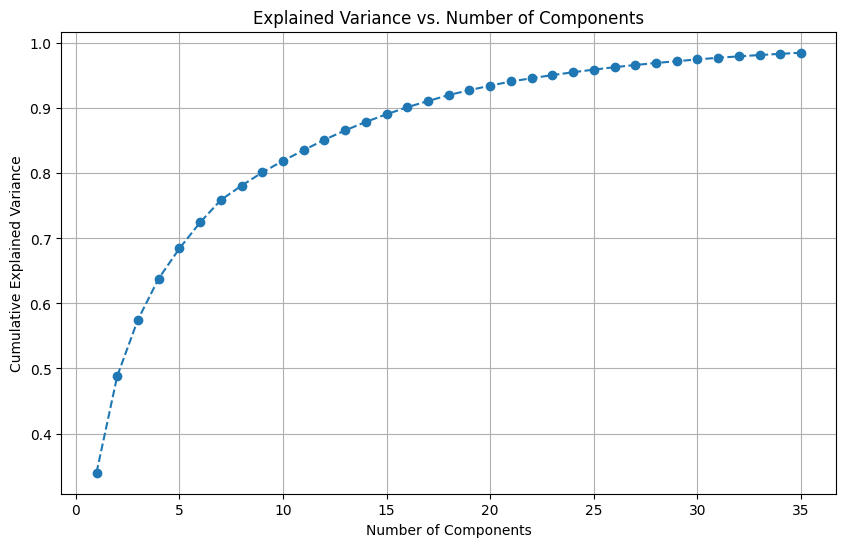

In [26]:
# Creating the principal components
pca = PCA(n_components=35)
X_pca = pca.fit_transform(X_scaled)
X_test_pca = pca.transform(X_test_scaled)

# plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

In [27]:
# Define parameter distribution for Lasso Regression
param_distribution = {
    'alpha': optuna.distributions.IntDistribution(0.1, 10),
    'max_iter': optuna.distributions.IntDistribution(700, 2000)
}

# Create Lasso Regression model
lasso_model = Lasso()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lasso_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for Lasso Regression: {optuna_search.best_params_}")
print(f"Best Mean RMSE for Lasso Regression: {optuna_search.best_score_:.4f}")

[I 2024-04-24 08:52:30,890] A new study created in memory with name: no-name-c4ecb683-2f83-491c-bf9f-3a7d7dcd0b14
[I 2024-04-24 08:52:30,921] Trial 0 finished with value: -64.33874855961501 and parameters: {'alpha': 2, 'max_iter': 1354}. Best is trial 0 with value: -64.33874855961501.
[I 2024-04-24 08:52:30,960] Trial 1 finished with value: -64.32840591431199 and parameters: {'alpha': 4, 'max_iter': 1825}. Best is trial 1 with value: -64.32840591431199.
[I 2024-04-24 08:52:31,001] Trial 2 finished with value: -64.21265046058716 and parameters: {'alpha': 7, 'max_iter': 1908}. Best is trial 2 with value: -64.21265046058716.
[I 2024-04-24 08:52:31,028] Trial 3 finished with value: -64.21265046058716 and parameters: {'alpha': 8, 'max_iter': 1831}. Best is trial 2 with value: -64.21265046058716.
[I 2024-04-24 08:52:31,054] Trial 4 finished with value: -64.21265046058716 and parameters: {'alpha': 6, 'max_iter': 757}. Best is trial 2 with value: -64.21265046058716.
[I 2024-04-24 08:52:31,076]

Best Parameters for Lasso Regression: {'alpha': 7, 'max_iter': 1908}
Best Mean RMSE for Lasso Regression: -64.2127


In [28]:
# Define parameter distribution for RandomForestRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 500),
    'max_depth': optuna.distributions.IntDistribution(5, 15),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
}

# Create RandomForestRegressor model
rf_model = RandomForestRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(rf_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for RandomForestRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for RandomForestRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 08:53:16,506] A new study created in memory with name: no-name-5d7b1372-3b96-4a49-9680-a67b484f9a79
[I 2024-04-24 08:53:25,427] Trial 0 finished with value: -64.25786079319437 and parameters: {'n_estimators': 157, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: -64.25786079319437.
[I 2024-04-24 08:53:56,882] Trial 1 finished with value: -64.0730749881249 and parameters: {'n_estimators': 276, 'max_depth': 8, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 1 with value: -64.0730749881249.
[I 2024-04-24 08:54:38,087] Trial 2 finished with value: -64.11118225681392 and parameters: {'n_estimators': 430, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: -64.0730749881249.
[I 2024-04-24 08:55:09,129] Trial 3 finished with value: -64.56644900474795 and parameters: {'n_estimators': 287, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 1 with value: -64.

Best Parameters for RandomForestRegressor: {'n_estimators': 105, 'max_depth': 7, 'min_samples_split': 8, 'min_samples_leaf': 2}
Best Mean RMSE for RandomForestRegressor: -62.4959


In [29]:
# Define parameter distribution for GradientBoostingRegressor
param_distribution = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4),
    'max_depth': optuna.distributions.IntDistribution(3, 10)
}

# Create GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(gb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for GradientBoostingRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for GradientBoostingRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 10:44:02,155] A new study created in memory with name: no-name-18bfa2be-350b-4260-950d-51c1c08218c3


[I 2024-04-24 10:44:07,713] Trial 0 finished with value: -77.30631031939906 and parameters: {'learning_rate': 0.040915029324686505, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 8}. Best is trial 0 with value: -77.30631031939906.
[I 2024-04-24 10:44:15,720] Trial 1 finished with value: -73.856436012624 and parameters: {'learning_rate': 0.07957583430795637, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 10}. Best is trial 1 with value: -73.856436012624.
[I 2024-04-24 10:44:18,799] Trial 2 finished with value: -65.40046713776808 and parameters: {'learning_rate': 0.05951668950230108, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 3}. Best is trial 2 with value: -65.40046713776808.
[I 2024-04-24 10:44:20,988] Trial 3 finished with value: -65.43893134470838 and parameters: {'learning_rate': 0.05253816363584151, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_depth': 3}. Best is trial 2 with value: -65.40046713776808.
[I 2024-04-24 10:44:26,373] T

Best Parameters for GradientBoostingRegressor: {'learning_rate': 0.025911320615494893, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3}
Best Mean RMSE for GradientBoostingRegressor: -61.9495


In [30]:
# Define parameter distribution for XGBRegressor
param_distribution = {
    'booster': optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-3, 1e-1)
}

# Create XGBRegressor model
xgb_model = XGBRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(xgb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for XGBRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for XGBRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 11:09:41,031] A new study created in memory with name: no-name-38a1e55e-01cc-4054-9327-cc20ac1fe9c7
[I 2024-04-24 11:09:41,678] Trial 0 finished with value: -64.85649279917014 and parameters: {'booster': 'gbtree', 'learning_rate': 0.012514018727817332, 'max_depth': 3, 'reg_lambda': 0.0951432086600396}. Best is trial 0 with value: -64.85649279917014.
[I 2024-04-24 11:09:41,820] Trial 1 finished with value: -74.68713855611239 and parameters: {'booster': 'gblinear', 'learning_rate': 0.08408282689492069, 'max_depth': 7, 'reg_lambda': 0.09111419094468347}. Best is trial 0 with value: -64.85649279917014.
[I 2024-04-24 11:09:41,959] Trial 2 finished with value: -72.71000682082348 and parameters: {'booster': 'gblinear', 'learning_rate': 0.02262351866990165, 'max_depth': 3, 'reg_lambda': 0.03786740904335781}. Best is trial 0 with value: -64.85649279917014.
[I 2024-04-24 11:09:44,436] Trial 3 finished with value: -83.87670282157303 and parameters: {'booster': 'gbtree', 'learning_ra

Best Parameters for XGBRegressor: {'booster': 'gblinear', 'learning_rate': 0.0010030095460362217, 'max_depth': 5, 'reg_lambda': 0.09819215335935158}
Best Mean RMSE for XGBRegressor: -64.1837


In [31]:
# Define parameter distribution for LGBMRegressor
param_distribution = {
    'boosting_type': optuna.distributions.CategoricalDistribution(['dart', 'gbdt']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'n_estimators': optuna.distributions.IntDistribution(100, 500)
}

# Create LGBMRegressor model
lgbm_model = LGBMRegressor(verbose=-1)

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lgbm_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for LGBMRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for LGBMRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 11:11:36,043] A new study created in memory with name: no-name-f994fe18-19a8-499e-8a02-f1d2e460759f


[I 2024-04-24 11:11:36,950] Trial 0 finished with value: -67.43872970800462 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.09106339052322529, 'max_depth': 3, 'n_estimators': 484}. Best is trial 0 with value: -67.43872970800462.
[I 2024-04-24 11:11:37,138] Trial 1 finished with value: -65.44244333082581 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.010940290231991088, 'max_depth': 8, 'n_estimators': 244}. Best is trial 1 with value: -65.44244333082581.
[I 2024-04-24 11:11:37,357] Trial 2 finished with value: -66.0293983097299 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04177321328595176, 'max_depth': 6, 'n_estimators': 226}. Best is trial 1 with value: -65.44244333082581.
[I 2024-04-24 11:11:37,560] Trial 3 finished with value: -89.66567190423714 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.029530271162673132, 'max_depth': 4, 'n_estimators': 185}. Best is trial 1 with value: -65.44244333082581.
[I 2024-04-24 11:11:37,918] Tri

Best Parameters for LGBMRegressor: {'boosting_type': 'gbdt', 'learning_rate': 0.0031091195661296232, 'max_depth': 5, 'n_estimators': 217}
Best Mean RMSE for LGBMRegressor: -63.3005


In [32]:
# Define parameter distribution for AdaBoostRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 600),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'loss': optuna.distributions.CategoricalDistribution(['linear', 'square', 'exponential'])
}

# Create AdaBoostRegressor model
adaboost_model = AdaBoostRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(adaboost_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for AdaBoostRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for AdaBoostRegressor: {optuna_search.best_score_:.4f}")

[I 2024-04-24 11:14:08,766] A new study created in memory with name: no-name-03378a88-c20f-4b4e-985e-4f8258a2d4f3
[I 2024-04-24 11:14:15,451] Trial 0 finished with value: -66.00619452123921 and parameters: {'n_estimators': 294, 'learning_rate': 0.022870285584914475, 'loss': 'linear'}. Best is trial 0 with value: -66.00619452123921.
[I 2024-04-24 11:14:25,246] Trial 1 finished with value: -63.0509661225689 and parameters: {'n_estimators': 461, 'learning_rate': 0.026446900075507443, 'loss': 'linear'}. Best is trial 1 with value: -63.0509661225689.
[I 2024-04-24 11:14:34,415] Trial 2 finished with value: -69.8342813027231 and parameters: {'n_estimators': 410, 'learning_rate': 0.009604172710620983, 'loss': 'linear'}. Best is trial 1 with value: -63.0509661225689.
[I 2024-04-24 11:14:48,560] Trial 3 finished with value: -69.52715782940594 and parameters: {'n_estimators': 599, 'learning_rate': 0.007474739227694218, 'loss': 'exponential'}. Best is trial 1 with value: -63.0509661225689.
[I 202

Best Parameters for AdaBoostRegressor: {'n_estimators': 591, 'learning_rate': 0.09057688897350245, 'loss': 'linear'}
Best Mean RMSE for AdaBoostRegressor: -56.5715


In [33]:
# Define parameter distribution for SVR
param_distribution = {
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'rbf', 'sigmoid']),
    'C': optuna.distributions.FloatDistribution(1e-3, 1e3),
    'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto'])
}

# Create SVR model
svr_model = SVR()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(svr_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X_pca, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for SVR: {optuna_search.best_params_}")
print(f"Best Mean RMSE for SVR: {optuna_search.best_score_:.4f}")

[I 2024-04-24 12:44:11,084] A new study created in memory with name: no-name-7172b901-101c-44ce-8748-756593ebfabb
[I 2024-04-24 12:44:16,836] Trial 0 finished with value: -110.60312634109316 and parameters: {'kernel': 'linear', 'C': 102.06480896640484, 'gamma': 'scale'}. Best is trial 0 with value: -110.60312634109316.
[I 2024-04-24 12:44:16,854] Trial 1 finished with value: -1071394.8212920881 and parameters: {'kernel': 'sigmoid', 'C': 312.76188450270564, 'gamma': 'auto'}. Best is trial 0 with value: -110.60312634109316.
[I 2024-04-24 12:44:35,501] Trial 2 finished with value: -110.60787558996965 and parameters: {'kernel': 'linear', 'C': 215.24229959208094, 'gamma': 'scale'}. Best is trial 0 with value: -110.60312634109316.
[I 2024-04-24 12:44:35,529] Trial 3 finished with value: -96.70983748163073 and parameters: {'kernel': 'rbf', 'C': 972.898563676892, 'gamma': 'scale'}. Best is trial 3 with value: -96.70983748163073.
[I 2024-04-24 12:44:35,548] Trial 4 finished with value: -3256354

Best Parameters for SVR: {'kernel': 'rbf', 'C': 13.126368117329006, 'gamma': 'auto'}
Best Mean RMSE for SVR: -77.3703


In [18]:
linear_pca = LinearRegression()

catboost_pca = CatBoostRegressor(verbose=0)

# Storing best hypertuned parameters for Lasso Regression
lasso_best_params = {'alpha': 1.7988305056684866, 'max_iter': 1231}
best_pca_lasso = Lasso(**lasso_best_params)

# Storing the best hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 125, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 1}
best_pca_rf = RandomForestRegressor(**rf_best_params)

# Storing the best hypertuned parameters for Gradient Boosting
gb_best_params = {'learning_rate': 0.0022376056265860185, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 9}
best_pca_gb = GradientBoostingRegressor(**gb_best_params)

# Storing the best hypertuned parameters for XGBoost
xgb_best_params = {'booster': 'gbtree', 'learning_rate': 0.0014223199599598104, 'max_depth': 10, 'reg_lambda': 0.0017636571853062498}
best_pca_xgb = XGBRegressor(**xgb_best_params)

# Storing the best hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.0011746473149660222, 'max_depth': 5, 'n_estimators': 115}
best_pca_lgbm = LGBMRegressor(**lgbm_best_params, verbose=-1)

# Storing the best hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 281, 'learning_rate': 0.05128640923184004, 'loss': 'square'}
best_pca_ada = AdaBoostRegressor(**ada_best_params)

# Storing the best hypertuned parameters for SVM
svm_best_params = {'kernel': 'rbf', 'C': 0.5824565355248112, 'gamma': 'auto'}
best_pca_svm = SVR(**svm_best_params)

In [19]:
# Training all the models with the best hyperparameters
linear_pca.fit(X_pca, y)
catboost_pca.fit(X, y)
best_pca_lasso.fit(X_pca, y)
best_pca_rf.fit(X_pca, y)
best_pca_gb.fit(X_pca, y)
best_pca_xgb.fit(X_pca, y)
best_pca_lgbm.fit(X_pca, y)
best_pca_ada.fit(X_pca, y)
best_pca_svm.fit(X_pca, y)

print("All hypertuned models (with PCA) trained")

All hypertuned models (with PCA) trained


In [20]:
predictions = linear_pca.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Linear Regression RMSE (with PCA): {rmse:.4f}')

predictions = catboost_pca.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'CatBoost RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_lasso.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Lasso RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_rf.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Random Forest RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_gb.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Gradient Boosting RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_xgb.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'XGBoost RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_lgbm.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'LightGBM RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_ada.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'AdaBoost RMSE (with PCA): {rmse:.4f}')

predictions = best_pca_svm.predict(X_test_pca)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'SVM RMSE (with PCA): {rmse:.4f}')

Linear Regression RMSE (with PCA): 6.6164
CatBoost RMSE (with PCA): 6.8963
Lasso RMSE (with PCA): 6.4498
Random Forest RMSE (with PCA): 6.8549
Gradient Boosting RMSE (with PCA): 6.5138
XGBoost RMSE (with PCA): 6.5164
LightGBM RMSE (with PCA): 6.5383
AdaBoost RMSE (with PCA): 6.7143
SVM RMSE (with PCA): 6.3367


#### Training models using the acoustic embedded features generated using OpenL3

In [ ]:
df = pd.read_csv(train_openl3)
df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_65,PCA_66,PCA_67,PCA_68,PCA_69,PCA_70,PCA_71,adressfname,mmse,dx
0,-27.350261,-11.547916,3.194821,3.233408,23.539571,23.975362,4.950868,19.616343,-5.034369,5.414441,...,0.006380,2.145519,0.188495,-0.701952,0.458338,1.706684,-0.544045,adrso024,20,ad
1,66.056891,-25.791742,3.862756,13.576992,0.404364,-17.442802,6.924843,44.695537,15.976963,8.786722,...,4.415965,-1.993021,3.262250,0.641830,-1.924304,-2.830352,0.520572,adrso025,11,ad
2,105.815696,-31.557052,-24.936550,17.809282,4.960485,1.856382,-1.160028,-12.552959,-7.260625,-8.934382,...,-2.263594,1.143174,-1.712436,2.534207,-0.801921,1.921143,-1.414975,adrso027,18,ad
3,89.408783,-22.635065,-16.626816,16.535224,8.251938,2.577151,5.088128,-8.306204,5.039446,-6.209638,...,2.484383,3.670945,0.333947,-1.309709,-0.535859,-3.206473,2.051542,adrso028,18,ad
4,81.721634,-30.463799,-24.435702,4.301633,4.869426,-22.117550,2.341473,1.638639,-2.461775,9.294784,...,3.921126,-0.848957,-0.916502,-2.012388,0.506803,-3.522666,-1.228324,adrso031,26,ad


In [ ]:
# Features and target variable
X = df.drop(['adressfname', 'dx', 'mmse'], axis=1)
y = df['mmse']

In [ ]:
# Define parameter distribution for Lasso Regression
param_distribution = {
    'alpha': optuna.distributions.FloatDistribution(0.1, 10),
    'max_iter': optuna.distributions.IntDistribution(700, 2000)
}

# Create Lasso Regression model
lasso_model = Lasso()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lasso_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for Lasso Regression: {optuna_search.best_params_}")
print(f"Best Mean RMSE for Lasso Regression: {optuna_search.best_score_:.4f}")

[I 2024-03-02 20:35:32,163] A new study created in memory with name: no-name-c1e8ada0-1804-4cbd-abf8-fef58d38da40
[I 2024-03-02 20:35:32,219] Trial 0 finished with value: 6.924987789663476 and parameters: {'alpha': 4.011848759873365, 'max_iter': 1463}. Best is trial 0 with value: 6.924987789663476.
[I 2024-03-02 20:35:32,268] Trial 1 finished with value: 7.053441578597672 and parameters: {'alpha': 2.2093865398794454, 'max_iter': 1083}. Best is trial 0 with value: 6.924987789663476.
[I 2024-03-02 20:35:32,343] Trial 2 finished with value: 11.120973870907571 and parameters: {'alpha': 0.13436447911818145, 'max_iter': 1439}. Best is trial 0 with value: 6.924987789663476.
[I 2024-03-02 20:35:32,415] Trial 3 finished with value: 11.304296218279887 and parameters: {'alpha': 0.12429316192016575, 'max_iter': 1000}. Best is trial 0 with value: 6.924987789663476.
[I 2024-03-02 20:35:32,525] Trial 4 finished with value: 6.910150815773401 and parameters: {'alpha': 3.476958581527768, 'max_iter': 103

Best Parameters for Lasso Regression: {'alpha': 3.4331722108901874, 'max_iter': 782}
Best Mean RMSE for Lasso Regression: 6.9100


In [ ]:
# Define parameter distribution for RandomForestRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 500),
    'max_depth': optuna.distributions.IntDistribution(5, 15),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4)
}

# Create RandomForestRegressor model
rf_model = RandomForestRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(rf_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for RandomForestRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for RandomForestRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-03 00:09:41,937] A new study created in memory with name: no-name-2b4c9206-4a21-41bd-a834-7cc35adeef98
[I 2024-03-03 00:10:15,381] Trial 0 finished with value: 7.320380393148537 and parameters: {'n_estimators': 473, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 1}. Best is trial 0 with value: 7.320380393148537.
[I 2024-03-03 00:10:24,678] Trial 1 finished with value: 7.3100335828855 and parameters: {'n_estimators': 121, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 1 with value: 7.3100335828855.
[I 2024-03-03 00:10:57,975] Trial 2 finished with value: 7.258770828265547 and parameters: {'n_estimators': 437, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 2 with value: 7.258770828265547.
[I 2024-03-03 00:11:19,799] Trial 3 finished with value: 7.330472442746211 and parameters: {'n_estimators': 340, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 2 with value: 7.2587708282

Best Parameters for Random Forest Regression: {'n_estimators': 291, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}
Best Mean RMSE for Random Forest Regression: 7.2038


In [ ]:
# Define parameter distribution for GradientBoostingRegressor
param_distribution = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'min_samples_leaf': optuna.distributions.IntDistribution(1, 4),
    'max_depth': optuna.distributions.IntDistribution(3, 10)
}

# Create GradientBoostingRegressor model
gb_model = GradientBoostingRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(gb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for GradientBoostingRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for GradientBoostingRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-03 02:17:23,880] A new study created in memory with name: no-name-9b3cd162-993d-4366-b4ab-6441cf034e91
[I 2024-03-03 02:17:31,164] Trial 0 finished with value: 7.237120119061968 and parameters: {'learning_rate': 0.005, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 7}. Best is trial 0 with value: 7.237120119061968.
[I 2024-03-03 02:17:40,833] Trial 1 finished with value: 8.168269659801002 and parameters: {'learning_rate': 0.05, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 6}. Best is trial 0 with value: 7.237120119061968.
[I 2024-03-03 02:17:46,917] Trial 2 finished with value: 7.898297562063725 and parameters: {'learning_rate': 0.05, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 4}. Best is trial 0 with value: 7.237120119061968.
[I 2024-03-03 02:17:55,842] Trial 3 finished with value: 7.894158655216367 and parameters: {'learning_rate': 0.05, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5}. Best is trial 0 with value:

Best Parameters for Gradient Boosting: {'learning_rate': 0.001, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 8}
Best Mean RMSE for Gradient Boosting: 6.9600


In [ ]:
# Define parameter distribution for XGBRegressor
param_distribution = {
    'booster': optuna.distributions.CategoricalDistribution(['gbtree', 'gblinear']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'reg_lambda': optuna.distributions.FloatDistribution(1e-3, 1e-1)
}

# Create XGBRegressor model
xgb_model = XGBRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(xgb_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for XGBRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for XGBRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-03 03:42:03,299] A new study created in memory with name: no-name-81f5ba74-a344-4a99-adfa-fc36f706c7bf
[I 2024-03-03 03:42:03,410] Trial 0 finished with value: 9.95270802716486 and parameters: {'booster': 'gblinear', 'learning_rate': 0.1, 'max_depth': 7, 'reg_lambda': 0.014231721674397011}. Best is trial 0 with value: 9.95270802716486.
[I 2024-03-03 03:42:03,479] Trial 1 finished with value: 13.351868667793715 and parameters: {'booster': 'gblinear', 'learning_rate': 0.5, 'max_depth': 8, 'reg_lambda': 0.0018069589252690994}. Best is trial 0 with value: 9.95270802716486.
[I 2024-03-03 03:42:03,547] Trial 2 finished with value: 7.026252059053763 and parameters: {'booster': 'gblinear', 'learning_rate': 0.01, 'max_depth': 9, 'reg_lambda': 0.011734340349061014}. Best is trial 2 with value: 7.026252059053763.
[I 2024-03-03 03:42:08,747] Trial 3 finished with value: 7.992261752227456 and parameters: {'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10, 'reg_lambda': 0.001361

Best Parameters for XGBoost: {'booster': 'gblinear', 'learning_rate': 0.005, 'max_depth': 8, 'reg_lambda': 0.09989673318205654}
Best Mean RMSE for XGBoost: 6.8608


In [ ]:
# Define parameter distribution for LGBMRegressor
param_distribution = {
    'boosting_type': optuna.distributions.CategoricalDistribution(['dart', 'gbdt']),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'max_depth': optuna.distributions.IntDistribution(3, 10),
    'n_estimators': optuna.distributions.IntDistribution(100, 500)
}

# Create LGBMRegressor model
lgbm_model = LGBMRegressor(verbose=-1)

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(lgbm_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for LGBMRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for LGBMRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-03 03:44:29,917] A new study created in memory with name: no-name-31f4d38b-e566-44b1-a8cf-02b2198e83ca
[I 2024-03-03 03:44:30,147] Trial 0 finished with value: 15.770871737211706 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 155}. Best is trial 0 with value: 15.770871737211706.
[I 2024-03-03 03:44:30,388] Trial 1 finished with value: 7.770304857452716 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 197}. Best is trial 1 with value: 7.770304857452716.
[I 2024-03-03 03:44:30,802] Trial 2 finished with value: 10.027799154775456 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 1, 'max_depth': 5, 'n_estimators': 430}. Best is trial 1 with value: 7.770304857452716.
[I 2024-03-03 03:44:31,029] Trial 3 finished with value: 9.019568834513583 and parameters: {'boosting_type': 'dart', 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 170}. Best is trial 1 with value: 7.770

Best Parameters for LightGBM: {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 153}
Best Mean RMSE for LightGBM: 6.9444


In [ ]:
# Define parameter distribution for AdaBoostRegressor
param_distribution = {
    'n_estimators': optuna.distributions.IntDistribution(100, 600),
    'learning_rate': optuna.distributions.FloatDistribution(1e-3, 1e-1),
    'loss': optuna.distributions.CategoricalDistribution(['linear', 'square', 'exponential'])
}

# Create AdaBoostRegressor model
adaboost_model = AdaBoostRegressor()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(adaboost_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for AdaBoostRegressor: {optuna_search.best_params_}")
print(f"Best Mean RMSE for AdaBoostRegressor: {optuna_search.best_score_:.4f}")

[I 2024-03-03 03:46:11,900] A new study created in memory with name: no-name-6f5aa997-d3cf-442e-9e31-326a3d4ac673
[I 2024-03-03 03:46:31,210] Trial 0 finished with value: 7.374145385627612 and parameters: {'n_estimators': 526, 'learning_rate': 0.01, 'loss': 'exponential'}. Best is trial 0 with value: 7.374145385627612.
[I 2024-03-03 03:46:37,417] Trial 1 finished with value: 7.496373551717783 and parameters: {'n_estimators': 193, 'learning_rate': 1, 'loss': 'linear'}. Best is trial 0 with value: 7.374145385627612.
[I 2024-03-03 03:46:49,459] Trial 2 finished with value: 7.4629985106900545 and parameters: {'n_estimators': 344, 'learning_rate': 0.1, 'loss': 'linear'}. Best is trial 0 with value: 7.374145385627612.
[I 2024-03-03 03:47:05,758] Trial 3 finished with value: 7.537884592219837 and parameters: {'n_estimators': 499, 'learning_rate': 0.5, 'loss': 'exponential'}. Best is trial 0 with value: 7.374145385627612.
[I 2024-03-03 03:47:18,266] Trial 4 finished with value: 7.4783311795295

Best Parameters for AdaBoost: {'n_estimators': 192, 'learning_rate': 0.01, 'loss': 'square'}
Best Mean RMSE for AdaBoost: 7.2333


In [ ]:
# Define parameter distribution for SVR
param_distribution = {
    'kernel': optuna.distributions.CategoricalDistribution(['linear', 'rbf', 'sigmoid']),
    'C': optuna.distributions.FloatDistribution(1e-3, 1e3),
    'gamma': optuna.distributions.CategoricalDistribution(['scale', 'auto'])
}

# Create SVR model
svr_model = SVR()

# Create OptunaSearchCV object
optuna_search = OptunaSearchCV(svr_model, param_distribution, n_trials=500, scoring='neg_mean_squared_error', cv=5)

# Fit the model
optuna_search.fit(X, y)

# Print the best parameters and corresponding RMSE for the model
print(f"Best Parameters for SVR: {optuna_search.best_params_}")
print(f"Best Mean RMSE for SVR: {optuna_search.best_score_:.4f}")

[I 2024-03-03 20:08:17,330] A new study created in memory with name: no-name-9c6b9992-7233-42d1-894f-64e826ff8ebf


[I 2024-03-03 20:08:17,618] Trial 0 finished with value: 9.228407026155812 and parameters: {'kernel': 'linear', 'C': 0.021471106166859922}. Best is trial 0 with value: 9.228407026155812.
[I 2024-03-03 20:08:17,673] Trial 1 finished with value: 6.956536490242196 and parameters: {'kernel': 'rbf', 'C': 196.85534156779707}. Best is trial 1 with value: 6.956536490242196.
[I 2024-03-03 20:18:57,116] Trial 2 finished with value: 16.06510385583198 and parameters: {'kernel': 'linear', 'C': 110.64000901576514}. Best is trial 1 with value: 6.956536490242196.
[I 2024-03-03 20:19:49,079] Trial 3 finished with value: 15.898622773855752 and parameters: {'kernel': 'linear', 'C': 5.511043566927797}. Best is trial 1 with value: 6.956536490242196.
[I 2024-03-03 20:19:49,115] Trial 4 finished with value: 1900.5059291102164 and parameters: {'kernel': 'sigmoid', 'C': 126.2508115743789}. Best is trial 1 with value: 6.956536490242196.
[I 2024-03-03 20:19:49,158] Trial 5 finished with value: 7.525251102293512 

Best Parameters for SVM: {'kernel': 'linear', 'C': 0.0021020406963522336}
Best Mean RMSE for SVM: 6.9377


In [6]:
linear_openl3 = LinearRegression()

catboost_openl3 = CatBoostRegressor(verbose=0)

# Storing the hypertuned parameters for Lasso Regression
lasso_best_params = {'alpha': 3.4331722108901874, 'max_iter': 782}
best_lasso = Lasso(**lasso_best_params)

# Storing the hypertuned parameters for Random Forest
rf_best_params = {'n_estimators': 291, 'max_depth': 5, 'min_samples_split': 4, 'min_samples_leaf': 4}
best_rf = RandomForestRegressor(**rf_best_params)

# Storing the hypertuned parameters for Gradient Boosting
gb_best_params = {'learning_rate': 0.001, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_depth': 8}
best_gb = GradientBoostingRegressor(**gb_best_params)

# Storing the hypertuned parameters for XGBoost
xgb_best_paramas = {'booster': 'gblinear', 'learning_rate': 0.005, 'max_depth': 8, 'reg_lambda': 0.09989673318205654}
best_xgb = XGBRegressor(**xgb_best_paramas)

# Storing the hypertuned parameters for LightGBM
lgbm_best_params = {'boosting_type': 'gbdt', 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 153}
best_lgbm = LGBMRegressor(**lgbm_best_params, verbose=-1)

# Storing the hypertuned parameters for AdaBoost
ada_best_params = {'n_estimators': 192, 'learning_rate': 0.01, 'loss': 'square'}
best_ada = AdaBoostRegressor(**ada_best_params)

# Storing the hypertuned parameters for SVM
svm_best_params = {'kernel': 'linear', 'C': 0.0021020406963522336}
best_svm = SVR(**svm_best_params)

In [7]:
# Training all the models with best parameters
linear_openl3.fit(X, y)
catboost_openl3.fit(X, y)
best_lasso.fit(X, y)
best_rf.fit(X, y)
best_gb.fit(X, y)
best_xgb.fit(X, y)
best_lgbm.fit(X, y)
best_ada.fit(X, y)
best_svm.fit(X, y)

print("All hypertuned regression models (with OpenL3 embedded features) trained")

All hypertuned regression models (with OpenL3 embedded features) trained


In [9]:
test_df = pd.read_csv(test_openl3)
ground_truth_df = pd.read_csv(truth_task2)

# Merging the test features with the ground truth
test_df = pd.merge(test_df, ground_truth_df, left_on='adressfname', right_on='ID')

X_test = test_df.drop(['adressfname', 'MMSE', 'ID'], axis=1)

In [10]:
# Predictions and RMSE for Linear Regression model
predictions = linear_openl3.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Linear Regression RMSE: {rmse:.4f}')

# Predictions and RMSE for CatBoost model
predictions = catboost_openl3.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'CatBoost RMSE: {rmse:.4f}')

# Predictions and RMSE for Lasso Regression model
predictions = best_lasso.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Lasso RMSE: {rmse:.4f}')

# Predictions and RMSE for Random Forest model
predictions = best_rf.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Random Forest RMSE: {rmse:.4f}')

# Predictions and RMSE for Gradient Boosting model
predictions = best_gb.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'Gradient Boosting RMSE: {rmse:.4f}')

# Predictions and RMSE for XGBoost model
predictions = best_xgb.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'XGBoost RMSE: {rmse:.4f}')

# Predictions and RMSE for LightGBM model
predictions = best_lgbm.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'LightGBM RMSE: {rmse:.4}')

# Predictions and RMSE for AdaBoost model
predictions = best_ada.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'AdaBoost RMSE: {rmse:.4f}')

# Predictions and RMSE for SVM model
predictions = best_svm.predict(X_test)
rounded_predictions = np.round(predictions)
rmse = mean_squared_error(test_df['MMSE'], rounded_predictions, squared=False)

print(f'SVM RMSE: {rmse:.4f}')

Linear Regression RMSE: 7.8961
CatBoost RMSE: 6.6233
Lasso RMSE: 6.9466
Random Forest RMSE: 6.3844
Gradient Boosting RMSE: 6.5402
XGBoost RMSE: 6.7173
LightGBM RMSE: 6.512
AdaBoost RMSE: 6.3494
SVM RMSE: 7.4816
